In [1]:
################################################
#### Jingying Wang <astro.jywang@gmail.com> ####
###############################################
#imports
import katdal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LogNorm
import time
import pickle
import sys
Tcmb=2.725
try:
    import katcali
except:
    import sys
    sys.path.insert(0, '/home/liutianyang/katcali')
    import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam_UHF as kb_u

from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
fname='1677011008'
# py_output_file='../level1/results/py_results/level1_20250306_092316/'
output_file=f'./results/py_results/level2_1677011008_20250527_131203/'

In [3]:
data=kio.load_data(fname)
#print data

In [4]:
#select ant, polarization, and one channel to show data calibration
ant='m011'
pol='v'
ch_plot= 3200 #ch3608 is for 1023MHz, but Tnd and Trec models cut at 1015MHz
#UHF ch_plot: (272,2869)+(3133,3547) 

# ratio_t = 0.4
# ratio_ch = 0.5
# ratios = "{:03d}".format(int(ratio_t * 100)) + "{:03d}".format(int(ratio_ch * 100))

In [5]:
#load data, labels, and parameters
ch_ref=ch_plot
data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])
print (corr_id,recv)

0 m011v


In [6]:
####save data####
d_r=pickle.load(open(output_file+str(fname)+'_'+str(recv)+'/level2_data','rb'))
T_map1=d_r['T_map']
Tresi_map1=d_r['Tresi_map']
gain_map1=d_r['gain_map']

Tnd_ref_list1=d_r['Tnd_ref_list']
Tnda_list1=d_r['Tnda_list']
Tndb_list1=d_r['Tndb_list']
Tnd_diff_ratio_list1=d_r['Tnd_diff_ratio_list']
NRMSE1_list1=d_r['NRMSE1_list']
NRMSE2_list1=d_r['NRMSE2_list']

d_r2=pickle.load(open(output_file+str(fname)+'_'+str(recv)+'/level2_Tnd_data','rb'))
Tnd_ref_list2=d_r2['Tnd_ref_list']
Tnda_list2=d_r2['Tnda_list']
Tndb_list2=d_r2['Tndb_list']

In [7]:
assert(Tnda_list1==Tnda_list2)
assert(Tndb_list1==Tndb_list2)

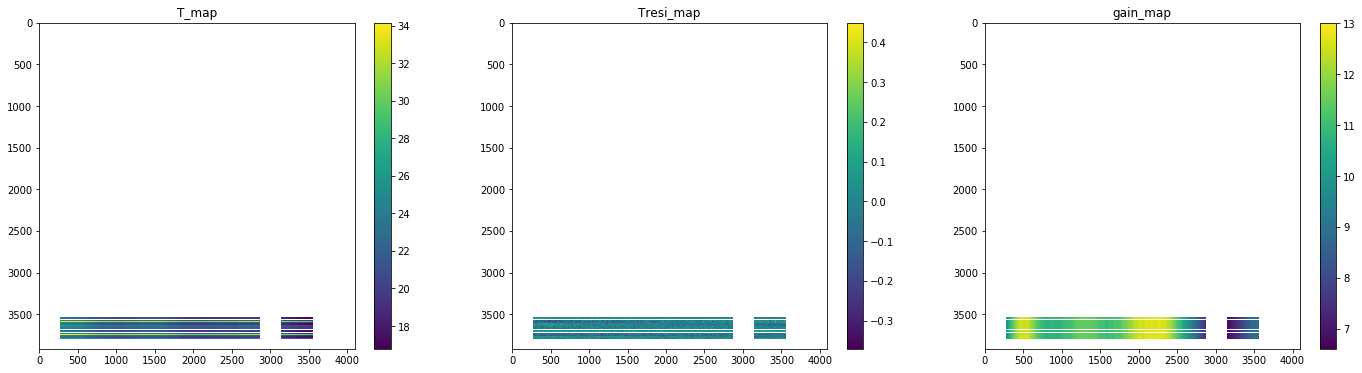

In [8]:
# T_map: raw data that are converted into temperature
# gain_map: the gain (a kind scaling factor) for comparison between raw data and model
plot_list=[T_map1,Tresi_map1,gain_map1]
plot_title=['T_map','Tresi_map','gain_map']
i=0
plt.figure(figsize=(8*len(plot_list),6))
for plot_d in plot_list:
    plt.subplot(1,len(plot_list),i+1)
    plt.imshow(plot_d,aspect='auto')
    plt.title(plot_title[i])
    plt.colorbar()
    i+=1
plt.show()

bad_ants: ['m006', 'm015', 'm016', 'm017', 'm020', 'm021', 'm036', 'm038']
calibrator number = 2
calibrator: EMPTY
calibrator: PictorA, ra,dec= 79d57m25.8149s, -45d46m43.7801s


Text(0,0.5,'Tnd_diff_ratio')

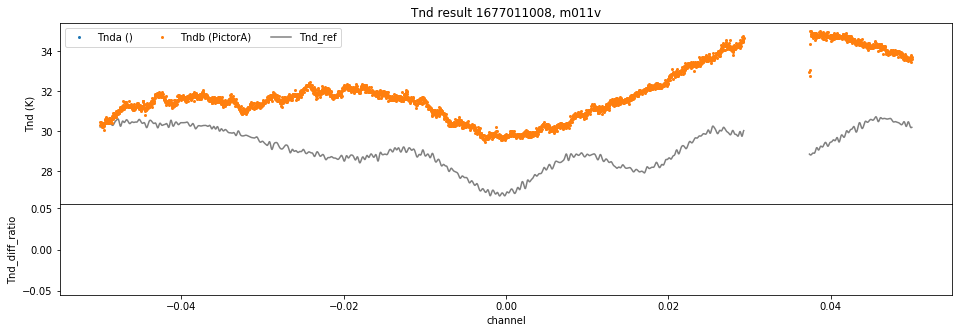

In [9]:
targets,c0s,bad_ants,flux_models=kio.check_ants(fname)
if isinstance(targets, list):
    target_list = targets.copy()
else:
    target_list = [targets, targets]
import matplotlib.gridspec as gridspec
plt.figure(figsize=(16,5))
plt.subplots_adjust(hspace=0)
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])
plt.subplot(gs[0,0])
plt.plot(Tnda_list1,'.',ms=4)
plt.plot(Tndb_list1,'.',ms=4)
plt.plot(Tnd_ref_list1, color='grey',zorder=0)
plt.legend([f'Tnda ({target_list[0]})',f'Tndb ({target_list[1]})','Tnd_ref'],ncol=3)
#plt.xlabel('channel')
plt.xticks([])
plt.ylabel('Tnd (K)')
plt.title('Tnd result '+fname+', '+recv)
plt.subplot(gs[1,0])
plt.plot(Tnd_diff_ratio_list1,'m.',ms=4)
plt.xlabel('channel')
plt.ylabel('Tnd_diff_ratio')
#plt.savefig(output_file+'Tnd_all_'+str(fname)+'_'+str(recv)+'.pdf', bbox_inches='tight')

In [65]:
fnames = ['1675210948', '1675623808', '1675643846', '1676313206', '1678295187', '1678743988', '1675632179', '1689176790', '1679247986', '1680626188']
dirs = ['level2_1675210948_20250522_183454', 'level2_1675623808_20250522_183555', 'level2_1675643846_20250522_183555', 'level2_1676313206_20250523_164748', 
       'level2_1678295187_20250523_164849', 'level2_1678743988_20250523_165044', 'level2_1675632179_20250522_183555', 'level2_1689176790_20250523_170250', 
       'level2_1679247986_20250526_175901', 'level2_1680626188_20250526_175912']

NRMSE_dict = {}
Tnd_diff_ratio_dict = {}
for pol in ['h', 'v']:
    for j, fname in enumerate(fnames):
        output_file=f'./results/py_results/{dirs[j]}/'
        
        data=kio.load_data(fname)
        
        total_NRMSE = []
        total_Tnd_diff_ratio = []
        for i in range(64):
            ant = f'm{i:03d}'
        
            try:
                #load data, labels, and parameters
                ch_ref=ch_plot
                data.select(ants=ant,pol=pol)
                recv=ant+pol
                corr_id=kio.cal_corr_id(data,recv)
                assert(recv==data.corr_products[corr_id][0])
                assert(recv==data.corr_products[corr_id][1])
            
                ####save data####
                d_r=pickle.load(open(output_file+str(fname)+'_'+str(recv)+'/level2_data','rb'))
                Tnd_diff_ratio_list1=d_r['Tnd_diff_ratio_list']
                NRMSE1_list1=d_r['NRMSE1_list']
                NRMSE2_list1=d_r['NRMSE2_list']
                
                NRMSE1_list = d_r['NRMSE1_list']
                NRMSE2_list = d_r['NRMSE2_list']
                NRMSE_list = NRMSE1_list + NRMSE2_list
                Tnd_diff_ratio_list = d_r['Tnd_diff_ratio_list']
                
                NRMSE = [x for x in NRMSE_list if x is not None]
                total_NRMSE.extend(NRMSE)
                Tnd_diff_ratio = [x for x in Tnd_diff_ratio_list if x is not None]
                total_Tnd_diff_ratio.extend(Tnd_diff_ratio)
                
                print(f'{recv} in {fname} is finished.')
            except Exception as e:
                print(f'{recv} in {fname} is skipped.')
            
        total_NRMSE = np.array(total_NRMSE)
        total_Tnd_diff_ratio = np.array(total_Tnd_diff_ratio)
        NRMSE_dict[f'{fname}_{pol}'] = np.median(total_NRMSE)
        Tnd_diff_ratio_dict[f'{fname}_{pol}'] = np.median(total_Tnd_diff_ratio)

m000h in 1675210948 is finished.
m001h in 1675210948 is finished.
m002h in 1675210948 is finished.
m003h in 1675210948 is finished.
m004h in 1675210948 is finished.


m005h in 1675210948 is finished.
m006h in 1675210948 is skipped.
m007h in 1675210948 is finished.
m008h in 1675210948 is finished.


m009h in 1675210948 is finished.
m010h in 1675210948 is skipped.
m011h in 1675210948 is finished.
m012h in 1675210948 is finished.
m013h in 1675210948 is finished.
m014h in 1675210948 is finished.
m015h in 1675210948 is finished.
m016h in 1675210948 is finished.
m017h in 1675210948 is finished.
m018h in 1675210948 is finished.


m019h in 1675210948 is finished.
m020h in 1675210948 is skipped.
m021h in 1675210948 is finished.
m022h in 1675210948 is finished.
m023h in 1675210948 is finished.
m024h in 1675210948 is skipped.
m025h in 1675210948 is finished.
m026h in 1675210948 is finished.
m027h in 1675210948 is finished.
m028h in 1675210948 is finished.
m029h in 1675210948 is finished.
m030h in 1675210948 is finished.
m031h in 1675210948 is finished.
m032h in 1675210948 is finished.
m033h in 1675210948 is finished.
m034h in 1675210948 is finished.
m035h in 1675210948 is finished.
m036h in 1675210948 is finished.
m037h in 1675210948 is skipped.
m038h in 1675210948 is finished.
m039h in 1675210948 is finished.
m040h in 1675210948 is finished.
m041h in 1675210948 is finished.
m042h in 1675210948 is finished.
m043h in 1675210948 is finished.
m044h in 1675210948 is finished.
m045h in 1675210948 is finished.
m046h in 1675210948 is finished.
m047h in 1675210948 is finished.
m048h in 1675210948 is finished.
m049h in 1675

m000h in 1675623808 is finished.
m001h in 1675623808 is finished.
m002h in 1675623808 is finished.
m003h in 1675623808 is finished.
m004h in 1675623808 is finished.
m005h in 1675623808 is finished.
m006h in 1675623808 is finished.
m007h in 1675623808 is finished.
m008h in 1675623808 is finished.
m009h in 1675623808 is finished.
m010h in 1675623808 is finished.
m011h in 1675623808 is finished.
m012h in 1675623808 is finished.
m013h in 1675623808 is finished.
m014h in 1675623808 is finished.


m015h in 1675623808 is finished.
m016h in 1675623808 is skipped.
m017h in 1675623808 is skipped.
m018h in 1675623808 is finished.


m019h in 1675623808 is finished.
m020h in 1675623808 is skipped.
m021h in 1675623808 is finished.
m022h in 1675623808 is finished.
m023h in 1675623808 is finished.
m024h in 1675623808 is skipped.
m025h in 1675623808 is finished.
m026h in 1675623808 is finished.
m027h in 1675623808 is finished.
m028h in 1675623808 is finished.
m029h in 1675623808 is finished.
m030h in 1675623808 is finished.
m031h in 1675623808 is finished.
m032h in 1675623808 is finished.
m033h in 1675623808 is finished.
m034h in 1675623808 is finished.


m035h in 1675623808 is finished.
m036h in 1675623808 is skipped.
m037h in 1675623808 is skipped.
m038h in 1675623808 is finished.
m039h in 1675623808 is finished.
m040h in 1675623808 is finished.
m041h in 1675623808 is finished.
m042h in 1675623808 is finished.
m043h in 1675623808 is finished.
m044h in 1675623808 is finished.
m045h in 1675623808 is finished.
m046h in 1675623808 is finished.
m047h in 1675623808 is finished.
m048h in 1675623808 is finished.
m049h in 1675623808 is finished.
m050h in 1675623808 is finished.
m051h in 1675623808 is finished.
m052h in 1675623808 is finished.
m053h in 1675623808 is finished.
m054h in 1675623808 is finished.
m055h in 1675623808 is finished.
m056h in 1675623808 is finished.
m057h in 1675623808 is finished.
m058h in 1675623808 is finished.
m059h in 1675623808 is finished.
m060h in 1675623808 is finished.
m061h in 1675623808 is finished.
m062h in 1675623808 is finished.
m063h in 1675623808 is finished.


m000h in 1675643846 is finished.
m001h in 1675643846 is finished.
m002h in 1675643846 is finished.
m003h in 1675643846 is finished.
m004h in 1675643846 is finished.
m005h in 1675643846 is finished.
m006h in 1675643846 is finished.
m007h in 1675643846 is finished.
m008h in 1675643846 is finished.
m009h in 1675643846 is finished.
m010h in 1675643846 is finished.
m011h in 1675643846 is finished.
m012h in 1675643846 is finished.
m013h in 1675643846 is finished.
m014h in 1675643846 is finished.
m015h in 1675643846 is finished.


m016h in 1675643846 is finished.
m017h in 1675643846 is skipped.
m018h in 1675643846 is finished.


m019h in 1675643846 is finished.
m020h in 1675643846 is skipped.
m021h in 1675643846 is finished.
m022h in 1675643846 is finished.
m023h in 1675643846 is finished.
m024h in 1675643846 is skipped.
m025h in 1675643846 is finished.
m026h in 1675643846 is finished.
m027h in 1675643846 is finished.
m028h in 1675643846 is finished.
m029h in 1675643846 is finished.
m030h in 1675643846 is finished.
m031h in 1675643846 is finished.
m032h in 1675643846 is finished.
m033h in 1675643846 is finished.
m034h in 1675643846 is finished.


m035h in 1675643846 is finished.
m036h in 1675643846 is skipped.
m037h in 1675643846 is skipped.
m038h in 1675643846 is finished.
m039h in 1675643846 is finished.
m040h in 1675643846 is finished.
m041h in 1675643846 is finished.
m042h in 1675643846 is finished.
m043h in 1675643846 is finished.
m044h in 1675643846 is finished.
m045h in 1675643846 is finished.
m046h in 1675643846 is finished.
m047h in 1675643846 is finished.
m048h in 1675643846 is finished.
m049h in 1675643846 is finished.
m050h in 1675643846 is finished.
m051h in 1675643846 is finished.
m052h in 1675643846 is finished.
m053h in 1675643846 is finished.
m054h in 1675643846 is finished.
m055h in 1675643846 is finished.
m056h in 1675643846 is finished.
m057h in 1675643846 is finished.
m058h in 1675643846 is finished.
m059h in 1675643846 is finished.
m060h in 1675643846 is finished.
m061h in 1675643846 is finished.
m062h in 1675643846 is finished.
m063h in 1675643846 is finished.


m000h in 1676313206 is finished.
m001h in 1676313206 is finished.
m002h in 1676313206 is finished.
m003h in 1676313206 is finished.
m004h in 1676313206 is finished.
m005h in 1676313206 is finished.
m006h in 1676313206 is finished.
m007h in 1676313206 is finished.
m008h in 1676313206 is finished.
m009h in 1676313206 is finished.
m010h in 1676313206 is finished.
m011h in 1676313206 is finished.


m012h in 1676313206 is finished.
m013h in 1676313206 is skipped.
m014h in 1676313206 is finished.
m015h in 1676313206 is finished.


m016h in 1676313206 is finished.
m017h in 1676313206 is skipped.
m018h in 1676313206 is finished.


m019h in 1676313206 is finished.
m020h in 1676313206 is skipped.
m021h in 1676313206 is finished.
m022h in 1676313206 is finished.
m023h in 1676313206 is finished.
m024h in 1676313206 is skipped.
m025h in 1676313206 is finished.
m026h in 1676313206 is finished.
m027h in 1676313206 is finished.
m028h in 1676313206 is finished.
m029h in 1676313206 is finished.
m030h in 1676313206 is finished.
m031h in 1676313206 is finished.
m032h in 1676313206 is finished.
m033h in 1676313206 is finished.
m034h in 1676313206 is finished.


m035h in 1676313206 is finished.
m036h in 1676313206 is skipped.
m037h in 1676313206 is skipped.
m038h in 1676313206 is finished.
m039h in 1676313206 is finished.
m040h in 1676313206 is finished.
m041h in 1676313206 is finished.
m042h in 1676313206 is finished.
m043h in 1676313206 is finished.
m044h in 1676313206 is finished.
m045h in 1676313206 is finished.
m046h in 1676313206 is finished.
m047h in 1676313206 is finished.
m048h in 1676313206 is finished.
m049h in 1676313206 is finished.
m050h in 1676313206 is finished.
m051h in 1676313206 is finished.
m052h in 1676313206 is finished.
m053h in 1676313206 is skipped.
m054h in 1676313206 is finished.
m055h in 1676313206 is finished.
m056h in 1676313206 is skipped.
m057h in 1676313206 is finished.
m058h in 1676313206 is finished.
m059h in 1676313206 is finished.
m060h in 1676313206 is skipped.
m061h in 1676313206 is skipped.
m062h in 1676313206 is finished.
m063h in 1676313206 is finished.


m000h in 1678295187 is finished.
m001h in 1678295187 is finished.
m002h in 1678295187 is skipped.
m003h in 1678295187 is finished.
m004h in 1678295187 is finished.
m005h in 1678295187 is finished.
m006h in 1678295187 is finished.
m007h in 1678295187 is finished.
m008h in 1678295187 is finished.
m009h in 1678295187 is finished.
m010h in 1678295187 is finished.
m011h in 1678295187 is finished.
m012h in 1678295187 is finished.
m013h in 1678295187 is finished.


m014h in 1678295187 is finished.
m015h in 1678295187 is skipped.


m016h in 1678295187 is finished.
m017h in 1678295187 is skipped.
m018h in 1678295187 is finished.
m019h in 1678295187 is finished.


m020h in 1678295187 is finished.
m021h in 1678295187 is skipped.
m022h in 1678295187 is skipped.
m023h in 1678295187 is skipped.
m024h in 1678295187 is skipped.
m025h in 1678295187 is finished.
m026h in 1678295187 is finished.
m027h in 1678295187 is finished.
m028h in 1678295187 is finished.
m029h in 1678295187 is finished.
m030h in 1678295187 is finished.
m031h in 1678295187 is finished.
m032h in 1678295187 is finished.
m033h in 1678295187 is skipped.
m034h in 1678295187 is finished.
m035h in 1678295187 is finished.
m036h in 1678295187 is finished.
m037h in 1678295187 is skipped.
m038h in 1678295187 is finished.
m039h in 1678295187 is finished.
m040h in 1678295187 is finished.
m041h in 1678295187 is finished.
m042h in 1678295187 is finished.
m043h in 1678295187 is finished.
m044h in 1678295187 is finished.
m045h in 1678295187 is finished.
m046h in 1678295187 is finished.
m047h in 1678295187 is finished.
m048h in 1678295187 is finished.
m049h in 1678295187 is finished.


m050h in 1678295187 is finished.
m051h in 1678295187 is skipped.
m052h in 1678295187 is finished.
m053h in 1678295187 is finished.
m054h in 1678295187 is finished.


m055h in 1678295187 is finished.
m056h in 1678295187 is skipped.
m057h in 1678295187 is finished.
m058h in 1678295187 is finished.
m059h in 1678295187 is finished.
m060h in 1678295187 is finished.
m061h in 1678295187 is finished.
m062h in 1678295187 is finished.
m063h in 1678295187 is finished.


m000h in 1678743988 is finished.
m001h in 1678743988 is finished.
m002h in 1678743988 is skipped.
m003h in 1678743988 is finished.
m004h in 1678743988 is finished.
m005h in 1678743988 is finished.
m006h in 1678743988 is finished.
m007h in 1678743988 is finished.
m008h in 1678743988 is finished.
m009h in 1678743988 is finished.
m010h in 1678743988 is skipped.
m011h in 1678743988 is finished.
m012h in 1678743988 is skipped.
m013h in 1678743988 is finished.
m014h in 1678743988 is finished.
m015h in 1678743988 is finished.


m016h in 1678743988 is finished.
m017h in 1678743988 is skipped.
m018h in 1678743988 is finished.
m019h in 1678743988 is finished.
m020h in 1678743988 is finished.
m021h in 1678743988 is finished.
m022h in 1678743988 is finished.
m023h in 1678743988 is finished.
m024h in 1678743988 is skipped.
m025h in 1678743988 is skipped.
m026h in 1678743988 is finished.
m027h in 1678743988 is finished.
m028h in 1678743988 is finished.
m029h in 1678743988 is finished.
m030h in 1678743988 is finished.
m031h in 1678743988 is finished.
m032h in 1678743988 is finished.
m033h in 1678743988 is finished.
m034h in 1678743988 is finished.
m035h in 1678743988 is finished.
m036h in 1678743988 is finished.
m037h in 1678743988 is skipped.
m038h in 1678743988 is finished.
m039h in 1678743988 is finished.
m040h in 1678743988 is finished.
m041h in 1678743988 is finished.
m042h in 1678743988 is skipped.
m043h in 1678743988 is finished.
m044h in 1678743988 is finished.
m045h in 1678743988 is finished.
m046h in 167874

m047h in 1678743988 is finished.
m048h in 1678743988 is skipped.
m049h in 1678743988 is finished.
m050h in 1678743988 is finished.
m051h in 1678743988 is finished.
m052h in 1678743988 is finished.
m053h in 1678743988 is finished.
m054h in 1678743988 is finished.
m055h in 1678743988 is finished.
m056h in 1678743988 is finished.


m057h in 1678743988 is finished.
m058h in 1678743988 is skipped.


m059h in 1678743988 is finished.
m060h in 1678743988 is skipped.
m061h in 1678743988 is finished.


m062h in 1678743988 is finished.
m063h in 1678743988 is skipped.


m000h in 1675632179 is finished.
m001h in 1675632179 is finished.
m002h in 1675632179 is finished.
m003h in 1675632179 is finished.
m004h in 1675632179 is finished.
m005h in 1675632179 is finished.
m006h in 1675632179 is finished.
m007h in 1675632179 is finished.
m008h in 1675632179 is finished.
m009h in 1675632179 is finished.
m010h in 1675632179 is finished.
m011h in 1675632179 is finished.
m012h in 1675632179 is finished.
m013h in 1675632179 is finished.
m014h in 1675632179 is finished.


m015h in 1675632179 is finished.
m016h in 1675632179 is skipped.
m017h in 1675632179 is skipped.
m018h in 1675632179 is finished.


m019h in 1675632179 is finished.
m020h in 1675632179 is skipped.
m021h in 1675632179 is finished.
m022h in 1675632179 is finished.
m023h in 1675632179 is finished.
m024h in 1675632179 is skipped.
m025h in 1675632179 is finished.
m026h in 1675632179 is finished.
m027h in 1675632179 is finished.
m028h in 1675632179 is finished.
m029h in 1675632179 is finished.
m030h in 1675632179 is finished.
m031h in 1675632179 is finished.
m032h in 1675632179 is finished.
m033h in 1675632179 is finished.
m034h in 1675632179 is finished.


m035h in 1675632179 is finished.
m036h in 1675632179 is skipped.
m037h in 1675632179 is skipped.
m038h in 1675632179 is finished.
m039h in 1675632179 is finished.
m040h in 1675632179 is finished.
m041h in 1675632179 is finished.
m042h in 1675632179 is finished.
m043h in 1675632179 is finished.
m044h in 1675632179 is finished.
m045h in 1675632179 is finished.
m046h in 1675632179 is finished.
m047h in 1675632179 is finished.
m048h in 1675632179 is finished.
m049h in 1675632179 is finished.
m050h in 1675632179 is finished.
m051h in 1675632179 is finished.
m052h in 1675632179 is finished.
m053h in 1675632179 is finished.
m054h in 1675632179 is finished.
m055h in 1675632179 is finished.
m056h in 1675632179 is finished.
m057h in 1675632179 is finished.
m058h in 1675632179 is finished.
m059h in 1675632179 is finished.
m060h in 1675632179 is finished.
m061h in 1675632179 is finished.
m062h in 1675632179 is finished.
m063h in 1675632179 is finished.


m000h in 1689176790 is finished.
m001h in 1689176790 is finished.
m002h in 1689176790 is finished.
m003h in 1689176790 is finished.
m004h in 1689176790 is finished.
m005h in 1689176790 is finished.
m006h in 1689176790 is finished.
m007h in 1689176790 is finished.


m008h in 1689176790 is finished.
m009h in 1689176790 is skipped.
m010h in 1689176790 is finished.
m011h in 1689176790 is finished.
m012h in 1689176790 is finished.
m013h in 1689176790 is finished.
m014h in 1689176790 is finished.
m015h in 1689176790 is finished.


m016h in 1689176790 is finished.
m017h in 1689176790 is skipped.
m018h in 1689176790 is finished.
m019h in 1689176790 is finished.
m020h in 1689176790 is finished.
m021h in 1689176790 is finished.
m022h in 1689176790 is finished.
m023h in 1689176790 is finished.
m024h in 1689176790 is skipped.
m025h in 1689176790 is finished.
m026h in 1689176790 is finished.
m027h in 1689176790 is finished.
m028h in 1689176790 is finished.
m029h in 1689176790 is finished.
m030h in 1689176790 is finished.
m031h in 1689176790 is finished.
m032h in 1689176790 is finished.
m033h in 1689176790 is finished.
m034h in 1689176790 is finished.
m035h in 1689176790 is finished.
m036h in 1689176790 is finished.
m037h in 1689176790 is skipped.
m038h in 1689176790 is finished.
m039h in 1689176790 is finished.
m040h in 1689176790 is finished.
m041h in 1689176790 is finished.
m042h in 1689176790 is finished.
m043h in 1689176790 is finished.
m044h in 1689176790 is finished.
m045h in 1689176790 is finished.
m046h in 1689

m049h in 1689176790 is finished.
m050h in 1689176790 is skipped.
m051h in 1689176790 is finished.
m052h in 1689176790 is finished.
m053h in 1689176790 is finished.
m054h in 1689176790 is finished.
m055h in 1689176790 is finished.
m056h in 1689176790 is finished.
m057h in 1689176790 is finished.
m058h in 1689176790 is finished.
m059h in 1689176790 is finished.
m060h in 1689176790 is finished.
m061h in 1689176790 is finished.
m062h in 1689176790 is finished.
m063h in 1689176790 is finished.


m000h in 1679247986 is finished.
m001h in 1679247986 is finished.
m002h in 1679247986 is finished.
m003h in 1679247986 is finished.
m004h in 1679247986 is finished.
m005h in 1679247986 is finished.
m006h in 1679247986 is finished.
m007h in 1679247986 is finished.


m008h in 1679247986 is finished.
m009h in 1679247986 is skipped.
m010h in 1679247986 is finished.
m011h in 1679247986 is finished.
m012h in 1679247986 is finished.
m013h in 1679247986 is finished.
m014h in 1679247986 is finished.


m015h in 1679247986 is finished.
m016h in 1679247986 is skipped.
m017h in 1679247986 is skipped.
m018h in 1679247986 is finished.
m019h in 1679247986 is finished.
m020h in 1679247986 is finished.
m021h in 1679247986 is finished.
m022h in 1679247986 is finished.
m023h in 1679247986 is finished.
m024h in 1679247986 is skipped.
m025h in 1679247986 is finished.
m026h in 1679247986 is finished.
m027h in 1679247986 is finished.
m028h in 1679247986 is finished.
m029h in 1679247986 is finished.
m030h in 1679247986 is finished.
m031h in 1679247986 is finished.
m032h in 1679247986 is finished.
m033h in 1679247986 is finished.
m034h in 1679247986 is finished.
m035h in 1679247986 is finished.
m036h in 1679247986 is finished.
m037h in 1679247986 is skipped.
m038h in 1679247986 is finished.
m039h in 1679247986 is finished.
m040h in 1679247986 is finished.
m041h in 1679247986 is finished.
m042h in 1679247986 is finished.
m043h in 1679247986 is finished.
m044h in 1679247986 is finished.
m045h in 16792

m000h in 1680626188 is finished.
m001h in 1680626188 is finished.
m002h in 1680626188 is finished.
m003h in 1680626188 is finished.
m004h in 1680626188 is finished.
m005h in 1680626188 is finished.
m006h in 1680626188 is finished.
m007h in 1680626188 is finished.
m008h in 1680626188 is finished.
m009h in 1680626188 is finished.
m010h in 1680626188 is finished.
m011h in 1680626188 is finished.
m012h in 1680626188 is finished.
m013h in 1680626188 is finished.
m014h in 1680626188 is finished.
m015h in 1680626188 is finished.


m016h in 1680626188 is finished.
m017h in 1680626188 is skipped.
m018h in 1680626188 is finished.
m019h in 1680626188 is finished.
m020h in 1680626188 is finished.
m021h in 1680626188 is finished.
m022h in 1680626188 is finished.
m023h in 1680626188 is finished.
m024h in 1680626188 is skipped.
m025h in 1680626188 is finished.
m026h in 1680626188 is finished.
m027h in 1680626188 is finished.
m028h in 1680626188 is finished.


m029h in 1680626188 is finished.
m030h in 1680626188 is skipped.
m031h in 1680626188 is finished.


m032h in 1680626188 is finished.
m033h in 1680626188 is skipped.
m034h in 1680626188 is skipped.
m035h in 1680626188 is skipped.
m036h in 1680626188 is finished.
m037h in 1680626188 is skipped.
m038h in 1680626188 is finished.
m039h in 1680626188 is finished.
m040h in 1680626188 is finished.
m041h in 1680626188 is finished.
m042h in 1680626188 is finished.
m043h in 1680626188 is finished.
m044h in 1680626188 is finished.
m045h in 1680626188 is finished.
m046h in 1680626188 is finished.
m047h in 1680626188 is finished.
m048h in 1680626188 is finished.
m049h in 1680626188 is finished.
m050h in 1680626188 is finished.
m051h in 1680626188 is finished.
m052h in 1680626188 is finished.
m053h in 1680626188 is finished.
m054h in 1680626188 is finished.
m055h in 1680626188 is finished.
m056h in 1680626188 is finished.
m057h in 1680626188 is finished.
m058h in 1680626188 is finished.
m059h in 1680626188 is finished.
m060h in 1680626188 is finished.
m061h in 1680626188 is finished.
m062h in 16806

m000v in 1675210948 is finished.
m001v in 1675210948 is finished.
m002v in 1675210948 is finished.
m003v in 1675210948 is finished.
m004v in 1675210948 is finished.


m005v in 1675210948 is finished.
m006v in 1675210948 is skipped.
m007v in 1675210948 is finished.
m008v in 1675210948 is finished.


m009v in 1675210948 is finished.
m010v in 1675210948 is skipped.
m011v in 1675210948 is finished.
m012v in 1675210948 is finished.
m013v in 1675210948 is finished.
m014v in 1675210948 is finished.
m015v in 1675210948 is finished.
m016v in 1675210948 is finished.
m017v in 1675210948 is finished.
m018v in 1675210948 is finished.


m019v in 1675210948 is finished.
m020v in 1675210948 is skipped.
m021v in 1675210948 is finished.
m022v in 1675210948 is finished.
m023v in 1675210948 is finished.
m024v in 1675210948 is skipped.
m025v in 1675210948 is finished.
m026v in 1675210948 is finished.
m027v in 1675210948 is finished.
m028v in 1675210948 is finished.
m029v in 1675210948 is finished.
m030v in 1675210948 is finished.
m031v in 1675210948 is finished.
m032v in 1675210948 is finished.
m033v in 1675210948 is finished.
m034v in 1675210948 is finished.
m035v in 1675210948 is finished.
m036v in 1675210948 is finished.
m037v in 1675210948 is skipped.
m038v in 1675210948 is finished.
m039v in 1675210948 is finished.
m040v in 1675210948 is finished.
m041v in 1675210948 is finished.
m042v in 1675210948 is finished.
m043v in 1675210948 is finished.
m044v in 1675210948 is finished.
m045v in 1675210948 is finished.
m046v in 1675210948 is finished.
m047v in 1675210948 is finished.
m048v in 1675210948 is finished.
m049v in 1675

m000v in 1675623808 is finished.
m001v in 1675623808 is finished.
m002v in 1675623808 is finished.
m003v in 1675623808 is finished.
m004v in 1675623808 is finished.
m005v in 1675623808 is finished.
m006v in 1675623808 is finished.
m007v in 1675623808 is finished.
m008v in 1675623808 is finished.
m009v in 1675623808 is finished.
m010v in 1675623808 is finished.
m011v in 1675623808 is finished.
m012v in 1675623808 is finished.
m013v in 1675623808 is finished.
m014v in 1675623808 is finished.


m015v in 1675623808 is finished.
m016v in 1675623808 is skipped.
m017v in 1675623808 is skipped.
m018v in 1675623808 is finished.


m019v in 1675623808 is finished.
m020v in 1675623808 is skipped.
m021v in 1675623808 is finished.
m022v in 1675623808 is finished.
m023v in 1675623808 is finished.
m024v in 1675623808 is skipped.
m025v in 1675623808 is finished.
m026v in 1675623808 is finished.
m027v in 1675623808 is finished.
m028v in 1675623808 is finished.
m029v in 1675623808 is finished.
m030v in 1675623808 is finished.
m031v in 1675623808 is finished.
m032v in 1675623808 is finished.
m033v in 1675623808 is finished.
m034v in 1675623808 is finished.


m035v in 1675623808 is finished.
m036v in 1675623808 is skipped.
m037v in 1675623808 is skipped.
m038v in 1675623808 is finished.
m039v in 1675623808 is finished.
m040v in 1675623808 is finished.
m041v in 1675623808 is finished.
m042v in 1675623808 is finished.
m043v in 1675623808 is finished.
m044v in 1675623808 is finished.
m045v in 1675623808 is finished.
m046v in 1675623808 is finished.
m047v in 1675623808 is finished.
m048v in 1675623808 is finished.
m049v in 1675623808 is finished.
m050v in 1675623808 is finished.
m051v in 1675623808 is finished.
m052v in 1675623808 is finished.
m053v in 1675623808 is finished.
m054v in 1675623808 is finished.
m055v in 1675623808 is finished.
m056v in 1675623808 is finished.
m057v in 1675623808 is finished.
m058v in 1675623808 is finished.
m059v in 1675623808 is finished.
m060v in 1675623808 is finished.
m061v in 1675623808 is finished.
m062v in 1675623808 is finished.
m063v in 1675623808 is finished.


m000v in 1675643846 is finished.
m001v in 1675643846 is finished.
m002v in 1675643846 is finished.
m003v in 1675643846 is finished.
m004v in 1675643846 is finished.
m005v in 1675643846 is finished.
m006v in 1675643846 is finished.
m007v in 1675643846 is finished.
m008v in 1675643846 is finished.
m009v in 1675643846 is finished.
m010v in 1675643846 is finished.
m011v in 1675643846 is finished.
m012v in 1675643846 is finished.
m013v in 1675643846 is finished.
m014v in 1675643846 is finished.
m015v in 1675643846 is finished.


m016v in 1675643846 is finished.
m017v in 1675643846 is skipped.
m018v in 1675643846 is finished.


m019v in 1675643846 is finished.
m020v in 1675643846 is skipped.
m021v in 1675643846 is finished.
m022v in 1675643846 is finished.
m023v in 1675643846 is finished.
m024v in 1675643846 is skipped.
m025v in 1675643846 is finished.
m026v in 1675643846 is finished.
m027v in 1675643846 is finished.
m028v in 1675643846 is finished.
m029v in 1675643846 is finished.
m030v in 1675643846 is finished.
m031v in 1675643846 is finished.
m032v in 1675643846 is finished.
m033v in 1675643846 is finished.
m034v in 1675643846 is finished.


m035v in 1675643846 is finished.
m036v in 1675643846 is skipped.
m037v in 1675643846 is skipped.
m038v in 1675643846 is finished.
m039v in 1675643846 is finished.
m040v in 1675643846 is finished.
m041v in 1675643846 is finished.
m042v in 1675643846 is finished.
m043v in 1675643846 is finished.
m044v in 1675643846 is finished.
m045v in 1675643846 is finished.
m046v in 1675643846 is finished.
m047v in 1675643846 is finished.
m048v in 1675643846 is finished.
m049v in 1675643846 is finished.
m050v in 1675643846 is finished.
m051v in 1675643846 is finished.
m052v in 1675643846 is finished.
m053v in 1675643846 is finished.
m054v in 1675643846 is finished.
m055v in 1675643846 is finished.
m056v in 1675643846 is finished.
m057v in 1675643846 is finished.
m058v in 1675643846 is finished.
m059v in 1675643846 is finished.
m060v in 1675643846 is finished.
m061v in 1675643846 is finished.
m062v in 1675643846 is finished.
m063v in 1675643846 is finished.


m000v in 1676313206 is finished.
m001v in 1676313206 is finished.
m002v in 1676313206 is finished.
m003v in 1676313206 is finished.
m004v in 1676313206 is finished.
m005v in 1676313206 is finished.
m006v in 1676313206 is finished.
m007v in 1676313206 is finished.
m008v in 1676313206 is finished.
m009v in 1676313206 is finished.
m010v in 1676313206 is finished.
m011v in 1676313206 is finished.


m012v in 1676313206 is finished.
m013v in 1676313206 is skipped.
m014v in 1676313206 is finished.
m015v in 1676313206 is finished.


m016v in 1676313206 is finished.
m017v in 1676313206 is skipped.
m018v in 1676313206 is finished.


m019v in 1676313206 is finished.
m020v in 1676313206 is skipped.
m021v in 1676313206 is finished.
m022v in 1676313206 is finished.
m023v in 1676313206 is finished.
m024v in 1676313206 is skipped.
m025v in 1676313206 is finished.
m026v in 1676313206 is finished.
m027v in 1676313206 is finished.
m028v in 1676313206 is finished.
m029v in 1676313206 is finished.
m030v in 1676313206 is finished.
m031v in 1676313206 is finished.
m032v in 1676313206 is finished.
m033v in 1676313206 is finished.
m034v in 1676313206 is finished.


m035v in 1676313206 is finished.
m036v in 1676313206 is skipped.
m037v in 1676313206 is skipped.
m038v in 1676313206 is finished.
m039v in 1676313206 is finished.
m040v in 1676313206 is finished.
m041v in 1676313206 is finished.
m042v in 1676313206 is finished.
m043v in 1676313206 is finished.
m044v in 1676313206 is finished.
m045v in 1676313206 is finished.
m046v in 1676313206 is finished.
m047v in 1676313206 is finished.
m048v in 1676313206 is finished.
m049v in 1676313206 is finished.
m050v in 1676313206 is finished.
m051v in 1676313206 is finished.
m052v in 1676313206 is finished.
m053v in 1676313206 is finished.
m054v in 1676313206 is finished.
m055v in 1676313206 is finished.
m056v in 1676313206 is finished.
m057v in 1676313206 is finished.
m058v in 1676313206 is finished.
m059v in 1676313206 is finished.
m060v in 1676313206 is skipped.
m061v in 1676313206 is finished.
m062v in 1676313206 is finished.
m063v in 1676313206 is finished.


m000v in 1678295187 is finished.
m001v in 1678295187 is finished.
m002v in 1678295187 is finished.
m003v in 1678295187 is finished.
m004v in 1678295187 is finished.
m005v in 1678295187 is finished.
m006v in 1678295187 is finished.
m007v in 1678295187 is finished.
m008v in 1678295187 is finished.
m009v in 1678295187 is finished.
m010v in 1678295187 is finished.
m011v in 1678295187 is finished.
m012v in 1678295187 is finished.
m013v in 1678295187 is finished.


m014v in 1678295187 is finished.
m015v in 1678295187 is skipped.


m016v in 1678295187 is finished.
m017v in 1678295187 is skipped.
m018v in 1678295187 is finished.
m019v in 1678295187 is finished.


m020v in 1678295187 is finished.
m021v in 1678295187 is skipped.
m022v in 1678295187 is skipped.
m023v in 1678295187 is skipped.
m024v in 1678295187 is skipped.
m025v in 1678295187 is finished.
m026v in 1678295187 is finished.
m027v in 1678295187 is finished.
m028v in 1678295187 is finished.
m029v in 1678295187 is finished.
m030v in 1678295187 is finished.
m031v in 1678295187 is finished.
m032v in 1678295187 is finished.
m033v in 1678295187 is finished.
m034v in 1678295187 is finished.
m035v in 1678295187 is finished.
m036v in 1678295187 is finished.
m037v in 1678295187 is skipped.
m038v in 1678295187 is finished.
m039v in 1678295187 is finished.
m040v in 1678295187 is finished.
m041v in 1678295187 is finished.
m042v in 1678295187 is finished.
m043v in 1678295187 is finished.
m044v in 1678295187 is finished.
m045v in 1678295187 is finished.
m046v in 1678295187 is finished.
m047v in 1678295187 is finished.
m048v in 1678295187 is finished.
m049v in 1678295187 is finished.


m050v in 1678295187 is finished.
m051v in 1678295187 is skipped.
m052v in 1678295187 is finished.
m053v in 1678295187 is finished.
m054v in 1678295187 is finished.


m055v in 1678295187 is finished.
m056v in 1678295187 is skipped.
m057v in 1678295187 is finished.
m058v in 1678295187 is finished.
m059v in 1678295187 is finished.
m060v in 1678295187 is finished.
m061v in 1678295187 is finished.
m062v in 1678295187 is finished.
m063v in 1678295187 is finished.


m000v in 1678743988 is finished.
m001v in 1678743988 is finished.
m002v in 1678743988 is finished.
m003v in 1678743988 is finished.
m004v in 1678743988 is finished.
m005v in 1678743988 is finished.
m006v in 1678743988 is finished.
m007v in 1678743988 is finished.
m008v in 1678743988 is finished.
m009v in 1678743988 is finished.
m010v in 1678743988 is skipped.
m011v in 1678743988 is finished.
m012v in 1678743988 is skipped.
m013v in 1678743988 is finished.
m014v in 1678743988 is finished.
m015v in 1678743988 is finished.


m016v in 1678743988 is finished.
m017v in 1678743988 is skipped.
m018v in 1678743988 is finished.
m019v in 1678743988 is finished.
m020v in 1678743988 is finished.
m021v in 1678743988 is finished.
m022v in 1678743988 is finished.
m023v in 1678743988 is finished.
m024v in 1678743988 is skipped.
m025v in 1678743988 is skipped.
m026v in 1678743988 is finished.
m027v in 1678743988 is skipped.
m028v in 1678743988 is finished.
m029v in 1678743988 is finished.
m030v in 1678743988 is finished.
m031v in 1678743988 is finished.
m032v in 1678743988 is finished.
m033v in 1678743988 is finished.
m034v in 1678743988 is finished.
m035v in 1678743988 is finished.
m036v in 1678743988 is finished.
m037v in 1678743988 is skipped.
m038v in 1678743988 is finished.
m039v in 1678743988 is skipped.
m040v in 1678743988 is finished.
m041v in 1678743988 is skipped.
m042v in 1678743988 is skipped.
m043v in 1678743988 is finished.
m044v in 1678743988 is finished.
m045v in 1678743988 is finished.
m046v in 167874398

m047v in 1678743988 is finished.
m048v in 1678743988 is skipped.
m049v in 1678743988 is finished.
m050v in 1678743988 is finished.
m051v in 1678743988 is finished.
m052v in 1678743988 is finished.
m053v in 1678743988 is finished.
m054v in 1678743988 is finished.
m055v in 1678743988 is finished.
m056v in 1678743988 is finished.


m057v in 1678743988 is finished.
m058v in 1678743988 is skipped.


m059v in 1678743988 is finished.
m060v in 1678743988 is skipped.
m061v in 1678743988 is finished.


m062v in 1678743988 is finished.
m063v in 1678743988 is skipped.


m000v in 1675632179 is finished.
m001v in 1675632179 is finished.
m002v in 1675632179 is finished.
m003v in 1675632179 is finished.
m004v in 1675632179 is finished.
m005v in 1675632179 is finished.
m006v in 1675632179 is finished.
m007v in 1675632179 is finished.
m008v in 1675632179 is finished.
m009v in 1675632179 is finished.
m010v in 1675632179 is finished.
m011v in 1675632179 is finished.
m012v in 1675632179 is finished.
m013v in 1675632179 is finished.
m014v in 1675632179 is finished.


m015v in 1675632179 is finished.
m016v in 1675632179 is skipped.
m017v in 1675632179 is skipped.
m018v in 1675632179 is finished.


m019v in 1675632179 is finished.
m020v in 1675632179 is skipped.
m021v in 1675632179 is finished.
m022v in 1675632179 is finished.
m023v in 1675632179 is finished.
m024v in 1675632179 is skipped.
m025v in 1675632179 is finished.
m026v in 1675632179 is finished.
m027v in 1675632179 is finished.
m028v in 1675632179 is finished.
m029v in 1675632179 is finished.
m030v in 1675632179 is finished.
m031v in 1675632179 is finished.
m032v in 1675632179 is finished.
m033v in 1675632179 is finished.
m034v in 1675632179 is finished.


m035v in 1675632179 is finished.
m036v in 1675632179 is skipped.
m037v in 1675632179 is skipped.
m038v in 1675632179 is finished.
m039v in 1675632179 is finished.
m040v in 1675632179 is finished.
m041v in 1675632179 is finished.
m042v in 1675632179 is finished.
m043v in 1675632179 is finished.
m044v in 1675632179 is finished.
m045v in 1675632179 is finished.
m046v in 1675632179 is finished.
m047v in 1675632179 is finished.
m048v in 1675632179 is finished.
m049v in 1675632179 is finished.
m050v in 1675632179 is finished.
m051v in 1675632179 is finished.
m052v in 1675632179 is finished.
m053v in 1675632179 is finished.
m054v in 1675632179 is finished.
m055v in 1675632179 is finished.
m056v in 1675632179 is finished.
m057v in 1675632179 is finished.
m058v in 1675632179 is finished.
m059v in 1675632179 is finished.
m060v in 1675632179 is finished.
m061v in 1675632179 is finished.
m062v in 1675632179 is finished.
m063v in 1675632179 is finished.


m000v in 1689176790 is finished.
m001v in 1689176790 is finished.
m002v in 1689176790 is finished.
m003v in 1689176790 is finished.
m004v in 1689176790 is finished.
m005v in 1689176790 is finished.
m006v in 1689176790 is finished.
m007v in 1689176790 is finished.


m008v in 1689176790 is finished.
m009v in 1689176790 is skipped.
m010v in 1689176790 is finished.
m011v in 1689176790 is finished.
m012v in 1689176790 is finished.
m013v in 1689176790 is finished.
m014v in 1689176790 is finished.
m015v in 1689176790 is finished.


m016v in 1689176790 is finished.
m017v in 1689176790 is skipped.
m018v in 1689176790 is finished.
m019v in 1689176790 is finished.
m020v in 1689176790 is finished.
m021v in 1689176790 is finished.
m022v in 1689176790 is finished.
m023v in 1689176790 is finished.
m024v in 1689176790 is skipped.
m025v in 1689176790 is finished.
m026v in 1689176790 is finished.
m027v in 1689176790 is finished.
m028v in 1689176790 is finished.
m029v in 1689176790 is finished.
m030v in 1689176790 is finished.
m031v in 1689176790 is finished.
m032v in 1689176790 is finished.
m033v in 1689176790 is finished.
m034v in 1689176790 is finished.
m035v in 1689176790 is finished.
m036v in 1689176790 is finished.
m037v in 1689176790 is skipped.
m038v in 1689176790 is finished.
m039v in 1689176790 is finished.
m040v in 1689176790 is finished.
m041v in 1689176790 is finished.
m042v in 1689176790 is finished.
m043v in 1689176790 is finished.
m044v in 1689176790 is finished.
m045v in 1689176790 is finished.
m046v in 1689

m049v in 1689176790 is finished.
m050v in 1689176790 is skipped.
m051v in 1689176790 is finished.
m052v in 1689176790 is finished.
m053v in 1689176790 is finished.
m054v in 1689176790 is finished.
m055v in 1689176790 is finished.
m056v in 1689176790 is finished.
m057v in 1689176790 is finished.
m058v in 1689176790 is finished.
m059v in 1689176790 is finished.
m060v in 1689176790 is finished.
m061v in 1689176790 is finished.
m062v in 1689176790 is finished.
m063v in 1689176790 is finished.


m000v in 1679247986 is finished.
m001v in 1679247986 is finished.
m002v in 1679247986 is finished.
m003v in 1679247986 is finished.
m004v in 1679247986 is finished.
m005v in 1679247986 is finished.
m006v in 1679247986 is finished.
m007v in 1679247986 is finished.


m008v in 1679247986 is finished.
m009v in 1679247986 is skipped.
m010v in 1679247986 is finished.
m011v in 1679247986 is finished.
m012v in 1679247986 is finished.
m013v in 1679247986 is finished.
m014v in 1679247986 is finished.


m015v in 1679247986 is finished.
m016v in 1679247986 is skipped.
m017v in 1679247986 is skipped.
m018v in 1679247986 is finished.
m019v in 1679247986 is finished.
m020v in 1679247986 is finished.
m021v in 1679247986 is finished.
m022v in 1679247986 is finished.
m023v in 1679247986 is finished.
m024v in 1679247986 is skipped.
m025v in 1679247986 is finished.
m026v in 1679247986 is finished.
m027v in 1679247986 is finished.
m028v in 1679247986 is finished.
m029v in 1679247986 is finished.
m030v in 1679247986 is finished.
m031v in 1679247986 is finished.
m032v in 1679247986 is finished.
m033v in 1679247986 is finished.
m034v in 1679247986 is finished.
m035v in 1679247986 is finished.
m036v in 1679247986 is finished.
m037v in 1679247986 is skipped.
m038v in 1679247986 is finished.
m039v in 1679247986 is finished.
m040v in 1679247986 is finished.
m041v in 1679247986 is finished.
m042v in 1679247986 is finished.
m043v in 1679247986 is finished.
m044v in 1679247986 is finished.
m045v in 16792

m000v in 1680626188 is finished.
m001v in 1680626188 is finished.
m002v in 1680626188 is finished.
m003v in 1680626188 is finished.
m004v in 1680626188 is finished.
m005v in 1680626188 is finished.
m006v in 1680626188 is finished.
m007v in 1680626188 is finished.
m008v in 1680626188 is finished.
m009v in 1680626188 is finished.
m010v in 1680626188 is finished.
m011v in 1680626188 is finished.
m012v in 1680626188 is finished.
m013v in 1680626188 is finished.
m014v in 1680626188 is finished.
m015v in 1680626188 is finished.


m016v in 1680626188 is finished.
m017v in 1680626188 is skipped.
m018v in 1680626188 is finished.
m019v in 1680626188 is finished.
m020v in 1680626188 is finished.
m021v in 1680626188 is finished.
m022v in 1680626188 is finished.
m023v in 1680626188 is finished.
m024v in 1680626188 is skipped.
m025v in 1680626188 is finished.
m026v in 1680626188 is finished.
m027v in 1680626188 is finished.
m028v in 1680626188 is finished.


m029v in 1680626188 is finished.
m030v in 1680626188 is skipped.
m031v in 1680626188 is finished.


m032v in 1680626188 is finished.
m033v in 1680626188 is skipped.
m034v in 1680626188 is skipped.
m035v in 1680626188 is skipped.
m036v in 1680626188 is finished.
m037v in 1680626188 is skipped.
m038v in 1680626188 is finished.
m039v in 1680626188 is finished.
m040v in 1680626188 is finished.
m041v in 1680626188 is finished.
m042v in 1680626188 is finished.
m043v in 1680626188 is finished.
m044v in 1680626188 is finished.
m045v in 1680626188 is finished.
m046v in 1680626188 is finished.
m047v in 1680626188 is finished.
m048v in 1680626188 is finished.
m049v in 1680626188 is finished.
m050v in 1680626188 is finished.
m051v in 1680626188 is finished.
m052v in 1680626188 is finished.
m053v in 1680626188 is finished.
m054v in 1680626188 is finished.
m055v in 1680626188 is finished.
m056v in 1680626188 is finished.
m057v in 1680626188 is finished.
m058v in 1680626188 is finished.
m059v in 1680626188 is finished.
m060v in 1680626188 is finished.
m061v in 1680626188 is finished.
m062v in 16806

In [81]:
final_NRMSE_dicth = {}
final_Tnd_diff_ratio_dicth = {}
final_NRMSE_dictv = {}
final_Tnd_diff_ratio_dictv = {}
for key in NRMSE_dict.keys():
    target_list,c0_list,bad_ants,flux_model_list=kio.check_ants(key[:10])
    if isinstance(target_list, list):
        tag = 'different'
    else:
        tag = 'same'

    if key[-1] == 'h':
        final_NRMSE_dicth[key] = f'{tag}, {NRMSE_dict[key]:.4f}'
        final_Tnd_diff_ratio_dicth[key] = f'{tag}, {Tnd_diff_ratio_dict[key]:.3f}'
    if key[-1] == 'v':
        final_NRMSE_dictv[key] = f'{tag}, {NRMSE_dict[key]:.4f}'
        final_Tnd_diff_ratio_dictv[key] = f'{tag}, {Tnd_diff_ratio_dict[key]:.3f}'

bad_ants: ['m006', 'm010', 'm020']
calibrator number = 1
calibrator: 3C273, ra,dec= 187d16m40.4954s, 2d03m08.5979s
bad_ants: ['m017', 'm020', 'm036']
calibrator number = 2
calibrator: HydraA, ra,dec= 139d31m25.0212s, -12d05m43.8072s
calibrator: PictorA, ra,dec= 79d57m25.8149s, -45d46m43.7801s
bad_ants: ['m017', 'm020', 'm036']
calibrator number = 1
calibrator: 3C273, ra,dec= 187d16m40.4954s, 2d03m08.5979s
bad_ants: ['m013', 'm017', 'm020', 'm036']
calibrator number = 2
calibrator: HydraA, ra,dec= 139d31m25.0212s, -12d05m43.8072s
calibrator: PictorA, ra,dec= 79d57m25.8149s, -45d46m43.7801s
bad_ants: ['m015', 'm017', 'm021', 'm022', 'm023', 'm024', 'm051', 'm056']
calibrator number = 2
calibrator: HydraA, ra,dec= 139d31m25.0212s, -12d05m43.8072s
calibrator: PictorA, ra,dec= 79d57m25.8149s, -45d46m43.7801s
bad_ants: ['m017', 'm048', 'm058', 'm060', 'm063']
calibrator number = 1
calibrator: 3C273, ra,dec= 187d16m40.4954s, 2d03m08.5979s
bad_ants: ['m017', 'm020', 'm036']
calibrator number =

In [2]:
# 1675623808 level2_1675623808_20250522_183555  There are RFIs in two frequency areas for most of the antennas
# 1689176790 level2_1689176790_20250523_170250 m011v  Tnd in this antenna has obvious oscillations

fname='1689176790'
# py_output_file='../level1/results/py_results/level1_20250306_092316/'
output_file=f'./results/py_results/level2_1689176790_20250523_170250/'

data=kio.load_data(fname)

#select ant, polarization, and one channel to show data calibration
ant='m011'
pol='v'
ch_plot= 3200 #ch3608 is for 1023MHz, but Tnd and Trec models cut at 1015MHz

#load data, labels, and parameters
ch_ref=ch_plot
data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])
print (corr_id,recv)

0 m011v


In [3]:
def cal_tag(target):
    if target=='PKS1934-638':
        tag='1934-638'
    if target=='PKS2153-69':
        tag='2153-69'
    if target=='PictorA':
        tag='PictorA'
    if target=='3C273':
        tag='3C273'
    if target=='HydraA':
        tag='HydraA'
    if target=='3C353':
        tag='3C353'
    if target=='':
        tag=''
    return tag

In [4]:
target_list,c0_list,bad_ants,flux_model_list=kio.check_ants(fname)

vis,flags= kio.call_vis(fname,recv)
ra,dec,az,el=kio.load_coordinates(data)
timestamps,freqs=kio.load_tf(data)
dump_period=data.dump_period
if isinstance(target_list, list):
    ang_deg=kio.load_ang_deg2(ra,dec,c0_list)
else:
    ang_deg=kio.load_ang_deg(ra,dec,c0_list) #modeified for xcalib
ang_deg=np.array(ang_deg)
dp_tt,dp_ss,dp_f,dp_w, dp_t,dp_s,dp_slew,dp_stop=kl.cal_dp_label(data,flags,ant,pol,ch_ref,ang_deg)

tag_list=[] #modeified for xcalib
if isinstance(target_list, list):
    for target in target_list:
        tag=cal_tag(target)
        tag_list.append(tag)
else:
    tag_list=cal_tag(target_list)
print(tag_list, flush=False)

target_start_list=[] #modeified for xcalib
if isinstance(target_list, list):
    for tag in tag_list:
        if tag != '':
            data.select()
            data.select(targets=tag+'_u0.8')
            target_start=data.target_indices[0]
            target_start_list.append(target_start)
            data.select()
        else:
            target_start_list.append('')
else:
    data.select()
    data.select(targets=tag_list+'_u0.8')
    target_start_list=data.target_indices[0]
    data.select()
print(target_start_list)

nd_on_time,nd_cycle,nd_set=kd.cal_nd_basic_para(fname)
nd_on_edge,nd_off_edge=kd.cal_nd_edges(timestamps,nd_set,nd_cycle,nd_on_time)
nd_ratio,nd_0, nd_1x=kd.cal_nd_ratio(timestamps, nd_on_time, nd_on_edge, dump_period)
dp_ca,dp_cb,dp_c0a, dp_c1a,dp_c2a,dp_c3a,dp_c4a,dp_c0b,dp_c1b,dp_c2b,dp_c3b,dp_c4b,dp_c1a1,dp_c1a2,dp_c1a3,dp_c1b1,dp_c1b2,dp_c1b3=kl.cal_dp_c(fname,data,ant,pol,flags,ch_ref,dp_tt,dp_ss,ang_deg, target_start=target_start_list,n_src_off=4)
nd_t0,nd_t1x,nd_s0,nd_s1x,nd_t0_ca,nd_t0_cb,nd_t1x_ca,nd_t1x_cb=kl.cal_label_intersec(dp_tt,dp_ss,nd_0,nd_1x)

bad_ants: ['m009', 'm017', 'm050']
calibrator number = 1
calibrator: 3C273, ra,dec= 187d16m40.4954s, 2d03m08.5979s
['m011v' 'm011v']
3C273
1
edge number 0-463
*** diode 0 was fired out of timestamps list: -145.88669562339783 not in [0,8874.314571380615]
*** diode 1 was fired out of timestamps list: -126.41672110557556 not in [0,8874.314571380615]
*** diode 2 was fired out of timestamps list: -106.94674634933472 not in [0,8874.314571380615]
*** diode 3 was fired out of timestamps list: -87.47677183151245 not in [0,8874.314571380615]
*** diode 4 was fired out of timestamps list: -68.00679731369019 not in [0,8874.314571380615]
*** diode 5 was fired out of timestamps list: -48.53682279586792 not in [0,8874.314571380615]
*** diode 6 was fired out of timestamps list: -29.066848039627075 not in [0,8874.314571380615]
*** diode 7 was fired out of timestamps list: -9.59687352180481 not in [0,8874.314571380615]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)
deg filter start: 0.8000025590457595+

In [5]:
####save data####
d_r=pickle.load(open(output_file+str(fname)+'_'+str(recv)+'/level2_data','rb'))
T_map1=d_r['T_map']
Tresi_map1=d_r['Tresi_map']
gain_map1=d_r['gain_map']

Tnd_ref_list1=d_r['Tnd_ref_list']
Tnda_list1=d_r['Tnda_list']
Tndb_list1=d_r['Tndb_list']
Tnd_diff_ratio_list1=d_r['Tnd_diff_ratio_list']
NRMSE1_list1=d_r['NRMSE1_list']
NRMSE2_list1=d_r['NRMSE2_list']

d_r2=pickle.load(open(output_file+str(fname)+'_'+str(recv)+'/level2_Tnd_data','rb'))
Tnd_ref_list2=d_r2['Tnd_ref_list']
Tnda_list2=d_r2['Tnda_list']
Tndb_list2=d_r2['Tndb_list']

assert(Tnda_list1==Tnda_list2)
assert(Tndb_list1==Tndb_list2)

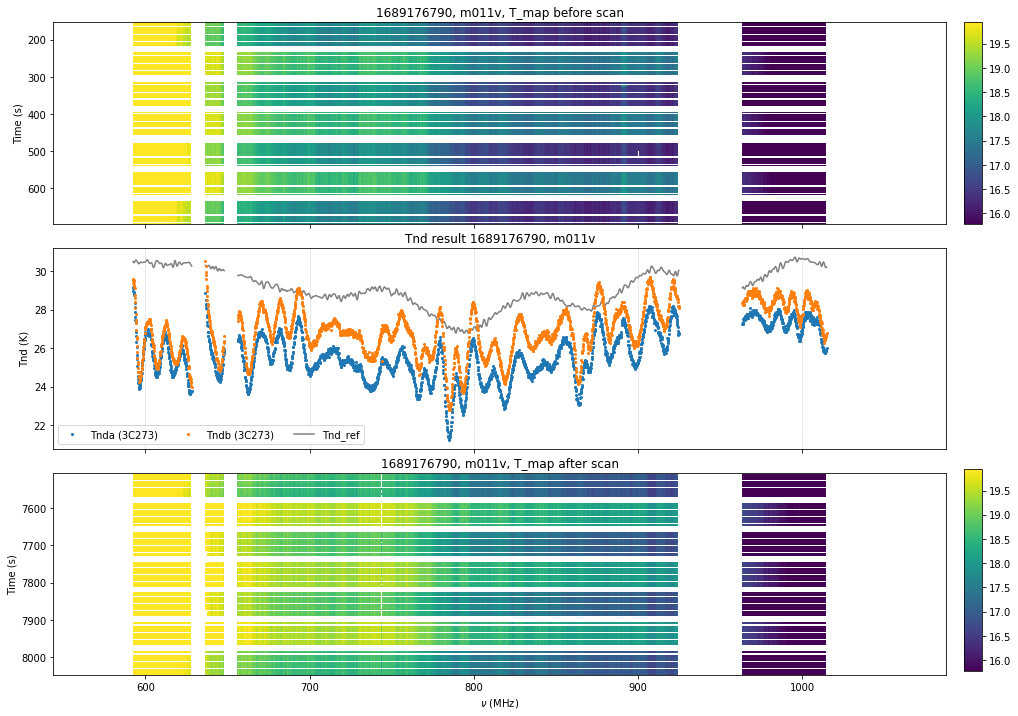

In [6]:
if isinstance(target_list, list):
    targets = target_list.copy()
else:
    targets = [target_list, target_list]

nd_t0_c = np.concatenate([nd_t0_ca, nd_t0_cb])
all_idx = np.arange(T_map1.shape[0])
nd_non_t0_c = np.setdiff1d(all_idx, nd_t0_c)
T_map1_4plot = T_map1.copy()
T_map1_4plot.mask[nd_non_t0_c, :] = True
if target_list[0] != '':
    dp_ta = np.arange(dp_ca[0], dp_ca[-1] + 1)
if target_list[-1] != '':
    dp_tb = np.arange(dp_cb[0], dp_cb[-1] + 1)
if target_list[0] == '':
    dp_ta = np.array([], dtype=int)
if target_list[-1] == '':
    dp_tb = np.array([], dtype=int)

if target_list[0] == '':
    extent1 = (freqs[0] / 1e6, freqs[-1] / 1e6, 1, 0)
else:
    extent1 = (freqs[0] / 1e6, freqs[-1] / 1e6, timestamps[dp_ta[-1]] - timestamps[0], timestamps[dp_ta[0]] - timestamps[0])
if target_list[1] == '':
    extent2 = (freqs[0] / 1e6, freqs[-1] / 1e6, 1, 0)
else:
    extent2 = (freqs[0] / 1e6, freqs[-1] / 1e6, timestamps[dp_tb[-1]] - timestamps[0], timestamps[dp_tb[0]] - timestamps[0])
plot_list=[T_map1_4plot[dp_ta, :], T_map1_4plot[dp_tb, :]]
plot_title=[f'{fname}, {recv}, T_map before scan', f'{fname}, {recv}, T_map after scan']
vmin = min(plot_list[0].min(), plot_list[1].min()) + 2
vmax = max(plot_list[0].max(), plot_list[1].max()) - 2

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(nrows=3, ncols=1)
fig.subplots_adjust(hspace=0.12)

ax0 = fig.add_subplot(gs[0, 0])
im0 = ax0.imshow(plot_list[0], extent=extent1, aspect='auto', vmin=vmin, vmax=vmax)
ax0.set_xlim(freqs[0] / 1e6, freqs[-1] / 1e6)
ax0.tick_params(axis='x', which='both', labelbottom=False) 
ax0.set_ylabel('Time (s)')
ax0.set_title(plot_title[0])
cax0 = inset_axes(ax0,
                 width="2%",  # 宽度为图像宽度的 2%
                 height="100%",  # 高度为图像高度的 100%
                 loc='lower left',
                 bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax0.transAxes,
                 borderpad=0)
fig.colorbar(im0, cax=cax0, orientation='vertical')

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(freqs / 1e6, Tnda_list1, '.', ms=4)
ax1.plot(freqs / 1e6, Tndb_list1, '.', ms=4)
ax1.plot(freqs / 1e6, Tnd_ref_list1, color='grey', zorder=0)
ax1.legend(
    [f'Tnda ({targets[0]})', f'Tndb ({targets[1]})', 'Tnd_ref'],
    ncol=3
)
ax1.set_xlim(freqs[0] / 1e6, freqs[-1] / 1e6)
ax1.tick_params(axis='x', which='both', labelbottom=False) 
ax1.set_ylabel('Tnd (K)')
ax1.set_title(f'Tnd result {fname}, {recv}')
ax1.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.8)

ax2 = fig.add_subplot(gs[2, 0])
ax2.set_xlim(freqs[0] / 1e6, freqs[-1] / 1e6)
im2 = ax2.imshow(plot_list[1], extent=extent2, aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel(r'$\nu$ (MHz)')
ax2.set_ylabel('Time (s)')
ax2.set_title(plot_title[1])
cax2 = inset_axes(ax2,
                 width="2%",  # 宽度为图像宽度的 2%
                 height="100%",  # 高度为图像高度的 100%
                 loc='lower left',
                 bbox_to_anchor=(1.02, -1.1, 1, 1),
                 bbox_transform=ax1.transAxes,
                 borderpad=0)
fig.colorbar(im2, cax=cax2, orientation='vertical')

# fig.savefig(output_file + f'Tnd_all_{fname}_{recv}.pdf', bbox_inches='tight')
plt.show()